In [1]:
import pandas as pd
import numpy as np
import os
import sys
import sqlalchemy as sqla
import csv
import matplotlib.pyplot as plt

## Database connection

In [2]:
DB_NAME = "postgres"
DB_USER = "postgres"
DB_PASS = "postgres"
DB_HOST = "localhost"
DB_PORT = "5432"

engine = sqla.create_engine(f"postgresql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}")
connection = engine.connect()

In [4]:
result = connection.execute(sqla.text("SELECT reltuples::bigint FROM pg_class WHERE relname='train_data'"))
estimated_count = result.scalar()
print(f"Approximate row count: {estimated_count}")

Approximate row count: 237373280


In [5]:
# Query statistics
query = """
SELECT 
    AVG(delay_departure) AS mean, 
    STDDEV(delay_departure) AS std_dev, 
    MIN(delay_departure) AS min_value, 
    MAX(delay_departure) AS max_value, 
    PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY delay_departure) AS q1,  -- 1st Quartile (25%)
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY delay_departure) AS median, -- Median (50%)
    PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY delay_departure) AS q3  -- 3rd Quartile (75%)
FROM train_data;
"""

result = connection.execute(sqla.text(query)).fetchone()

# Extract values
mean, std_dev, min_value, max_value, q1, median, q3 = result
print(f"Mean: {mean}, Std Dev: {std_dev}, Min: {min_value}, Max: {max_value}, Q1: {q1}, Median: {median}, Q3: {q3}")

Mean: 138.14009432351418, Std Dev: 412.15821109830193, Min: -170225.0, Max: 520659.0, Q1: 4.0, Median: 45.0, Q3: 146.0


In [6]:
# Query statistics
query = """
SELECT 
    AVG(delay_arrival) AS mean, 
    STDDEV(delay_arrival) AS std_dev, 
    MIN(delay_arrival) AS min_value, 
    MAX(delay_arrival) AS max_value, 
    PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY delay_arrival) AS q1,  -- 1st Quartile (25%)
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY delay_arrival) AS median, -- Median (50%)
    PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY delay_arrival) AS q3  -- 3rd Quartile (75%)
FROM train_data;
"""

result = connection.execute(sqla.text(query)).fetchone()

# Extract values
mean, std_dev, min_value, max_value, q1, median, q3 = result
print(f"Mean: {mean}, Std Dev: {std_dev}, Min: {min_value}, Max: {max_value}, Q1: {q1}, Median: {median}, Q3: {q3}")

Mean: 132.9522403512003, Std Dev: 497.09091508854004, Min: -170383.0, Max: 3960203.0, Q1: -4.0, Median: 42.0, Q3: 147.0


In [7]:
query = """
SELECT 
    EXTRACT(YEAR FROM departure_date) AS year, 
    COUNT(*) AS row_count, 
    
    AVG(delay_arrival) AS mean_arrival, 
    STDDEV(delay_arrival) AS std_dev_arrival, 
    MIN(delay_arrival) AS min_arrival, 
    MAX(delay_arrival) AS max_arrival, 
    PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY delay_arrival) AS q1_arrival,  
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY delay_arrival) AS median_arrival,  
    PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY delay_arrival) AS q3_arrival,  
    
    AVG(delay_departure) AS mean_departure, 
    STDDEV(delay_departure) AS std_dev_depature, 
    MIN(delay_departure) AS min_departure, 
    MAX(delay_departure) AS max_departure, 
    PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY delay_departure) AS q1_departure,  
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY delay_departure) AS median_departure,  
    PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY delay_departure) AS q3_departure  

FROM train_data
GROUP BY year
ORDER BY year;
"""

df = pd.read_sql(sqla.text(query), connection)

print(df)


      year  row_count  mean_arrival  std_dev_arrival  min_arrival  \
0   2014.0   21792638    140.901761       782.195965     -87123.0   
1   2015.0   21332468    116.212746       422.043395     -88466.0   
2   2016.0   21365904    142.676588       983.928616     -87991.0   
3   2017.0   21976359    154.041671       362.448139     -36020.0   
4   2018.0   22567297    157.051567       357.166114     -23647.0   
5   2019.0   22351850    127.954879       340.288502     -27108.0   
6   2020.0   21123945     88.462508       321.909442     -86716.0   
7   2021.0   22540713    101.203512       311.276038     -86509.0   
8   2022.0   22480415    136.710739       356.314059     -22368.0   
9   2023.0   22467606    153.358804       351.680582     -10779.0   
10  2024.0   23114728    141.385920       365.008272    -170383.0   

    max_arrival  q1_arrival  median_arrival  q3_arrival  mean_departure  \
0      520659.0         0.0            42.0       160.0      145.373122   
1      104450.0      

In [8]:
# SQL query to get statistics for both columns per month & year
query = """
SELECT 
    EXTRACT(YEAR FROM departure_date) AS year, 
    EXTRACT(MONTH FROM departure_date) AS month, 
    COUNT(*) AS row_count, 

    AVG(delay_arrival) AS mean_arrival, 
    STDDEV(delay_arrival) AS std_dev_arrival, 
    MIN(delay_arrival) AS min_arrival, 
    MAX(delay_arrival) AS max_arrival, 
    PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY delay_arrival) AS q1_arrival,  
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY delay_arrival) AS median_arrival,  
    PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY delay_arrival) AS q3_arrival,  
    
    AVG(delay_departure) AS mean_departure, 
    STDDEV(delay_departure) AS std_dev_depature, 
    MIN(delay_departure) AS min_departure, 
    MAX(delay_departure) AS max_departure, 
    PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY delay_departure) AS q1_departure,  
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY delay_departure) AS median_departure,  
    PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY delay_departure) AS q3_departure  
FROM train_data
GROUP BY year, month
ORDER BY year, month;
"""

df = pd.read_sql(sqla.text(query), connection)

print(df)

       year  month  row_count  mean_arrival  std_dev_arrival  min_arrival  \
0    2014.0    1.0    1900458    119.170084       399.625213     -36003.0   
1    2014.0    2.0    1734004    118.748212       630.960472     -86595.0   
2    2014.0    3.0    1868053    129.796352       472.707383     -83157.0   
3    2014.0    4.0    1824809    113.133004       433.310321     -86349.0   
4    2014.0    5.0    1839737    131.639121       369.524129     -85531.0   
..      ...    ...        ...           ...              ...          ...   
127  2024.0    8.0    1862513    122.777168       357.951857      -3466.0   
128  2024.0    9.0    1935800    146.573065       314.830648      -3636.0   
129  2024.0   10.0    2031774    139.467159       309.503791      -2740.0   
130  2024.0   11.0    1861370    161.628514       512.827980    -170383.0   
131  2024.0   12.0    1983701    114.129460       305.975623     -82489.0   

     max_arrival  q1_arrival  median_arrival  q3_arrival  mean_departure  \

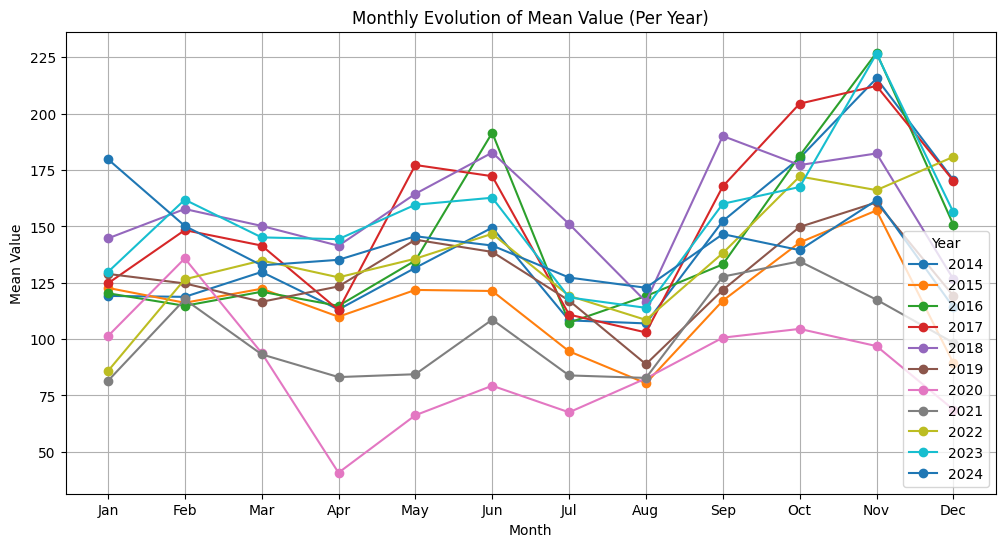

In [9]:
df["year"] = df["year"].astype(int)
df["month"] = df["month"].astype(int)

df["month"] = df["month"].astype(int)
df = df.sort_values(["year", "month"])

plt.figure(figsize=(12, 6))

for year, group in df.groupby("year"):
    plt.plot(group["month"], group["mean_arrival"], marker="o", linestyle="-", label=f"{year}")

plt.xticks(ticks=range(1, 13), labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])

plt.xlabel("Month")
plt.ylabel("Mean Value")
plt.title("Monthly Evolution of Mean Value (Per Year)")
plt.legend(title="Year")
plt.grid(True)

plt.show()

In [53]:
query = """
SELECT 
    TO_CHAR(departure_date, 'Day') AS weekday,
    EXTRACT(DOW FROM departure_date) AS weekday_number,
    AVG(delay_arrival) AS avg_arrival_delay,
    AVG(delay_departure) AS avg_departure_delay
FROM train_data
GROUP BY weekday, weekday_number
ORDER BY weekday_number;
"""

df = pd.read_sql(sqla.text(query), connection)

print(df)

     weekday  weekday_number  avg_arrival_delay  avg_departure_delay
0  Sunday                0.0         100.337964           108.013831
1  Monday                1.0         143.720395           148.257006
2  Tuesday               2.0         139.719646           144.336916
3  Wednesday             3.0         133.782585           138.508522
4  Thursday              4.0         138.109238           142.782252
5  Friday                5.0         142.523834           147.261583
6  Saturday              6.0         108.512081           115.779139


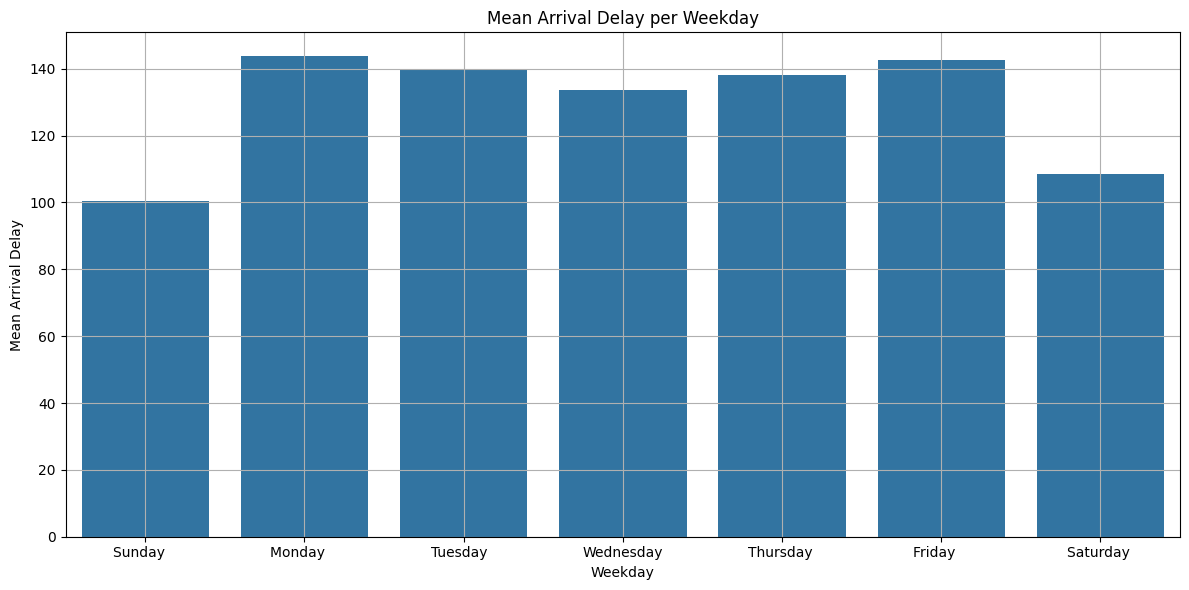

In [11]:
# using sns to plot the data in a bar chart
import seaborn as sns


plt.figure(figsize=(12, 6))
sns.barplot(x="weekday", y="avg_arrival_delay", data=df)
plt.xlabel("Weekday")
plt.ylabel("Mean Arrival Delay")
plt.title("Mean Arrival Delay per Weekday")
plt.grid(True)
plt.tight_layout()
plt.show()


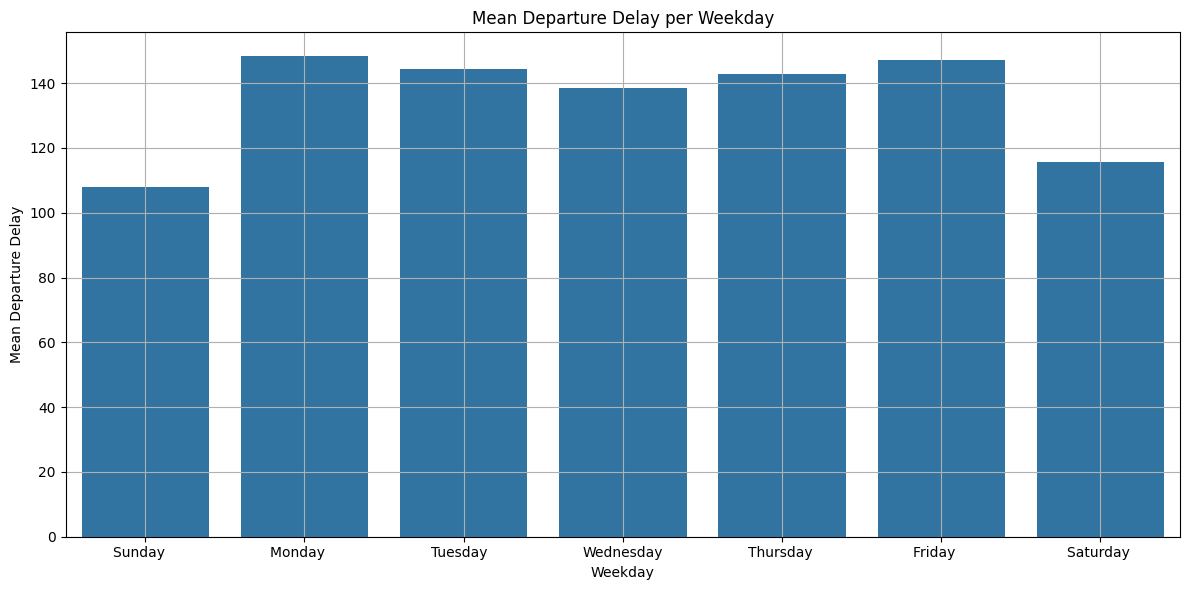

In [12]:
plt.figure(figsize=(12, 6))
sns.barplot(x="weekday", y="avg_departure_delay", data=df)
plt.xlabel("Weekday")
plt.ylabel("Mean Departure Delay")
plt.title("Mean Departure Delay per Weekday")
plt.grid(True)
plt.tight_layout()
plt.show()

## INDEX TENTATIVES

In [ ]:
query = """ CREATE INDEX idx_station_check ON train_data (ptcar_name,station_departure, station_arrival);"""

try :
    connection.execute(sqla.text(query))
except Exception as e:
    print(e)

(psycopg2.errors.DuplicateTable) relation "idx_station_check" already exists

[SQL:  CREATE INDEX idx_station_check ON DATANASE (ptcar_name,station_departure, station_arrival);]
(Background on this error at: https://sqlalche.me/e/20/f405)


In [ ]:
query = """DROP INDEX IF EXISTS idx_station_check;"""
try:
    connection.execute(sqla.text(query))
except Exception as e:
    print(e)
    connection.rollback()

#query = """DROP INDEX idx_null_check ON train_data;"""

#connection.execute(sqla.text(query))


In [ ]:
query = """ 
SELECT * 
FROM train_data
WHERE 
    station_departure = 0 OR  
    station_arrival = 0; 
"""

df = pd.read_sql(sqla.text(query), connection)

In [20]:

print(len(df))

## EDA CONT

In [13]:
query = """
    SELECT SERVICE.name, COUNT(train_data.train_service) AS Train_service_count
    FROM train_data
    LEFT JOIN SERVICE ON train_data.train_service = SERVICE.id
    GROUP BY SERVICE.name
    ORDER BY Train_service_count ASC;
"""

try :
    df = pd.read_sql(sqla.text(query), connection)
    display(df)
except Exception as e:
    print(e)
    connection.rollback()


,name,train_service_count
0,CAPTRAIN,3
1,RAILTRAXX,5
2,CROSSRAIL,50
3,BELGORAIL,97
4,EURSLEEPER,12286
5,EUROSTAR,87583
6,EUROSTARFR,159784
7,THI-FACT,2251383
8,SNCB/NMBS,240602732


In [51]:
query = """
    SELECT * from train_data WHERE train_service = 5;
"""

try :
    df = pd.read_sql(sqla.text(query), connection)
    display(df["relation"].unique())
except Exception as e:
    print(e)
    connection.rollback()

array([58])

In [14]:
query = """
    SELECT RELATION.name, COUNT(train_data.relation) AS Relation_count
    FROM train_data
    LEFT JOIN RELATION ON train_data.relation = RELATION.id
    GROUP BY RELATION.name
    ORDER BY Relation_count ASC;
"""

try :
    df = pd.read_sql(sqla.text(query), connection)
    display(df)
except Exception as e:
    print(e)
    connection.rollback()

,name,relation_count
0,None,0
1,L A2-2,152
2,S8-P,758
3,THAL 03,1619
4,L L37-2,2080
...,...,...
212,IC 18,4981537
213,IC 01,5772051
214,IC 25,7625935
215,P,12834054


In [16]:
query = """
    SELECT STATIONS.name, COUNT(train_data.ptcar_name) AS STATION_count
    FROM train_data
    LEFT JOIN STATIONS ON train_data.ptcar_name = STATIONS.id
    GROUP BY STATIONS.name
    ORDER BY STATION_count ASC;
"""

try :
    df = pd.read_sql(sqla.text(query), connection)
    display(df)
except Exception as e:
    print(e)
    connection.rollback()

,name,station_count
0,FELUY-ZONING,1
1,EIJSDEN,1
2,CLABECQ-MARCHANDISES,1
3,TROISVIERGES,1
4,ROTTERDAM CENTRAAL,1
...,...,...
786,BRUSSEL-CONGRES,3897367
787,BRUSSEL-KAPELLEKERK,3897420
788,BRUSSEL-CENTRAAL,3897471
789,BRUSSEL-NOORD,3915972


In [21]:
query = """
   SELECT train_data.ptcar_name, STATIONS.name, COUNT(train_data.ptcar_name) AS STATION_count 
FROM train_data
LEFT JOIN STATIONS ON train_data.ptcar_name = STATIONS.id
GROUP BY train_data.ptcar_name, STATIONS.name
HAVING COUNT(train_data.ptcar_name) < 10
ORDER BY STATION_count ASC;
"""

try :
    df = pd.read_sql(sqla.text(query), connection)
    display(df)
except Exception as e:
    print(e)
    connection.rollback()

,ptcar_name,name,station_count
0,188,CLABECQ,1
1,189,CLABECQ-MARCHANDISES,1
2,226,EIJSDEN,1
3,637,ROTTERDAM CENTRAAL,1
4,759,VOROUX-BASE TRAVAUX LGV,1
5,30,ANTWERPEN-D.S.-IJSLAND,1
6,31,ANTWERPEN-D.S.-LILLO,1
7,535,MONCEAU-CHARGEMENT GASOIL,1
8,33,ANTWERPEN-D.S.-PETROL,1
9,34,ANTWERPEN-D.S.-WILMARSDONK,1


In [40]:
connection.rollback()

In [41]:
toCheck = df["ptcar_name"].astype(int).tolist()
print(toCheck)
query = sqla.text("SELECT * FROM train_data WHERE ptcar_name IN :values")
df_result = pd.read_sql(query, connection, params={"values": tuple(toCheck)})

[188, 189, 226, 637, 759, 30, 31, 535, 33, 34, 467, 446, 295, 24, 254, 733, 285, 29, 63, 297, 487, 543, 702, 32, 62, 51, 336, 288, 36, 60, 807, 296, 27, 26, 293, 25, 806, 802, 46, 790]


In [42]:
print(df_result)

    departure_date  train_number  relation  train_service  ptcar_number  \
0       2014-03-03         17906         2              7          1505   
1       2014-01-16         17914         2              7           861   
2       2014-01-16         17916         2              7           861   
3       2014-03-26         17937         2              7          1505   
4       2014-04-24         17907         2              7          1505   
..             ...           ...       ...            ...           ...   
119     2024-10-05           783       165              7          1888   
120     2024-10-05           782       165              7          1888   
121     2024-10-05           784       165              7          1888   
122     2024-11-05         14402         0              7          1722   
123     2024-11-05         14403         0              7          1722   

    line_number_departure real_time_arrival real_time_departure  \
0                   27L/5       

In [55]:
query = """
   WITH Total AS (
    SELECT COUNT(*) AS total_trains FROM TRAIN_DATA
)
SELECT 
    relation, 
    COUNT(delay_arrival) AS count_trains,
    AVG(delay_arrival) AS mean_delay_arrival,
    (COUNT(delay_arrival) * 100.0 / (SELECT total_trains FROM Total)) AS percentage_trains
FROM TRAIN_DATA
GROUP BY relation
ORDER BY mean_delay_arrival DESC;
"""

try :
    df = pd.read_sql(sqla.text(query), connection)
    display(df)
except Exception as e:
    print(e)
    connection.rollback()

,relation,count_trains,mean_delay_arrival,percentage_trains
0,0.0,32352,627.930483,1.330734e-02
1,212.0,1707797,414.350366,7.024678e-01
2,56.0,864033,371.466828,3.554025e-01
3,1.0,273281,367.744849,1.124086e-01
4,215.0,1613,362.127092,6.634750e-04
...,...,...,...,...
212,176.0,1872,27.180556,7.700094e-04
213,93.0,99788,25.521726,4.104578e-02
214,91.0,22956,24.591697,9.442487e-03
215,26.0,24752,12.083791,1.018124e-02


In [58]:
query = """
SELECT 
    (100.0 * SUM(CASE WHEN delay_arrival > 300 THEN 1 ELSE 0 END) / COUNT(*)) AS percentage_greater_than_zero
FROM train_data;
"""

try :
    df = pd.read_sql(sqla.text(query), connection)
    display(df)
except Exception as e:
    print(e)
    connection.rollback()

,percentage_greater_than_zero
0,11.9828
